# Audio-ECoG cross-correlation

This is a quality control check to see if A1 electrodes respond to the audio envelope

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn.plotting import plot_markers
from mne_bids import BIDSPath

from scipy import signal
from scipy.io import wavfile
from scipy.signal import convolve, correlate, correlation_lags, windows

In [2]:
def xcorr(
    x: np.ndarray,
    y: np.ndarray,
    smooth_win=None,
    mode="full",
    method="fft",
    norm=True,
    maxlags=None,
    rank=False,
):
    """General function to compute cross correlation using scipy

    This function will center the data and normalize it by default.
    """

    # Rank transform
    if rank:
        x = x.argsort().argsort()
        y = y.argsort().argsort()

    # Center
    x = x - x.mean()
    y = y - y.mean()

    # Correlate
    corr = correlate(x, y, mode=mode, method=method)
    lags = correlation_lags(x.size, y.size, mode=mode)

    if norm:
        corr /= np.sqrt(np.dot(x, x) * np.dot(y, y))

    if maxlags is not None:
        middle = (lags == 0).nonzero()[0].item()
        lags = np.arange(-maxlags, maxlags + 1)
        corr = corr[middle - maxlags : middle + maxlags + 1]

    # Smooth the correlations
    # look at https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    # to get rid of edge effects
    if smooth_win is not None:
        win = windows.hamming(smooth_win)
        corr = convolve(corr, win, mode="same") / sum(win)

    return corr, lags


def preprocess_highqa(x, fs, to_fs, lowcut=200, highcut=5000):

    # See https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = signal.butter(order, [low, high], btype="band")
        return b, a

    def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = signal.lfilter(b, a, data)
        return y

    assert x.ndim == 1
    # x = x[:fs * round(len(x) / fs)]  # trim to nearest second

    # Step 1. Bandpass the high quality audio
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=5)

    # Step 2. Downsample to same freq as clinical system
    # Number of new samples is N = n * (to_fs / fs)
    y = signal.resample(y, num=round(x.size / fs * to_fs))

    # Step 3. Take audio envelope
    envelope = np.abs(signal.hilbert(y - y.mean()))

    return envelope

In [3]:
sfreq = 512
audio_path = "../monkey/stimuli/monkey.wav"
highfs, highqa = wavfile.read(audio_path)
if highqa.ndim > 1:
    highqa = highqa[:, 0]  # take first channel
highenv = preprocess_highqa(highqa, highfs, sfreq)

/tmp/ipykernel_4025037/3757069057.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  highfs, highqa = wavfile.read(audio_path)


In [4]:
edf_path = BIDSPath(root="../monkey/derivatives/ecogprep", datatype="ieeg", extension=".fif")
edf_paths = edf_path.match()
# hacky way just to get highgamma since `desc` doesn't work
edf_paths = [path for path in edf_paths if 'highgamma' in str(path)]
len(edf_paths)

8

In [5]:
raw = mne.io.read_raw_fif(edf_paths[1])
raw

Opening raw data file ../monkey/derivatives/ecogprep/sub-02/ieeg/sub-02_task-monkey_desc-highgamma_ieeg.fif...
    Range : 0 ... 921599 =      0.000 ...  1799.998 secs
Ready.


<Raw | sub-02_task-monkey_desc-highgamma_ieeg.fif, 186 x 921600 (1800.0 s), ~217 kB, data not loaded>

In [6]:
data = raw.get_data()
data.shape

(186, 921600)

In [8]:
data = data[184:185]
data.shape

(1, 921600)

In [9]:
all_corrs = []
for i in range(len(data)):
    corrs, lags = xcorr(highenv, data[i], maxlags=10*512)
    all_corrs.append(corrs)

In [10]:
all_corrs = np.stack(all_corrs)
all_corrs.shape

(1, 10241)

In [7]:
raw.info['ch_names'][184]

'DRPI3'

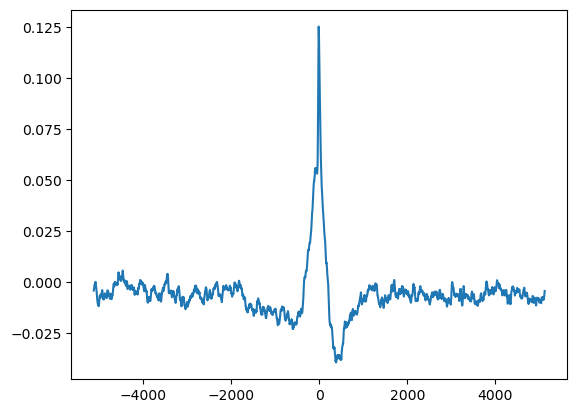

In [11]:
plt.plot(lags, all_corrs.mean(0))

In [21]:
best_elec = all_corrs.max(-1).argmax()
best_elec

184

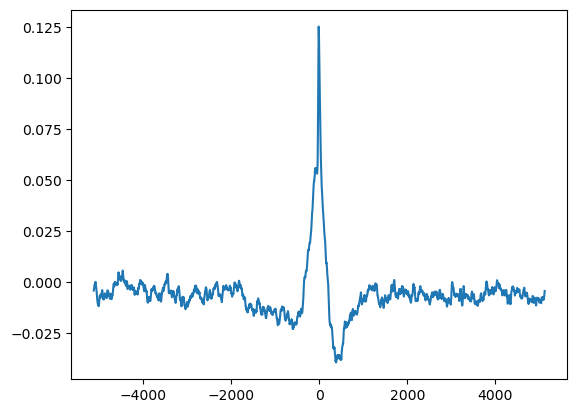

In [23]:
plt.plot(lags, all_corrs[best_elec])

In [13]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
coords.shape

(186, 3)

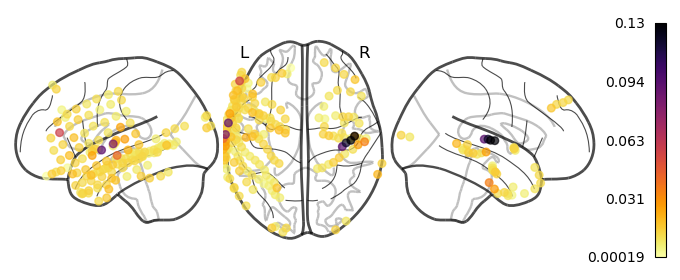

In [20]:
values = all_corrs.max(-1)
order = values.argsort()#[::-1]
plot_markers(values[order], coords[order],
                node_size=30, display_mode='lzr',
                node_cmap='inferno_r', colorbar=True)
plt.show()

In [56]:
values = all_corrs.max(-1)
np.percentile(values, 90)

0.01887601501996835

In [58]:
mask = values >= .02
mask.sum()

17

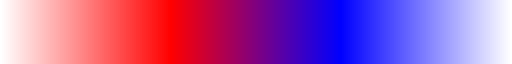

In [39]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('wrw', ["white", "red", "blue", "white"], N=256)
cmap

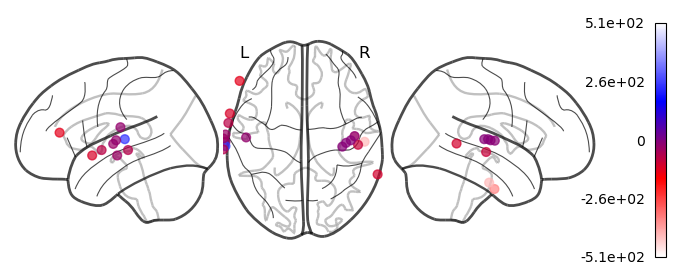

In [60]:
values = lags[all_corrs.argmax(-1)]
plot_markers(values[mask], coords[mask],
             node_size=40, display_mode='lzr',
             node_cmap=cmap, colorbar=True, node_vmin=-512, node_vmax=512)
plt.show()